Import main libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


Import main functions.

In [3]:
def data_info(table):
    table.info(memory_usage='deep')
    display(table.head(5))

def unique_check(table,column):
    max_value = table[column].max()
    min_value = table[column].min()
    display(max_value,min_value)
    display(table[column].value_counts())

def show_stat (target,prediction):
    accuracy = accuracy_score(target,prediction)
    recall = recall_score(target,prediction)
    precision = precision_score(target,prediction)
    conf = confusion_matrix(target,prediction)
    TP = conf[1,1]
    TN = conf[0,0]
    FP = conf[0,1]
    FN = conf[1,0]
    f1 = f1_score(target,prediction)
    rocauc = roc_auc_score(target,prediction)
    stats = {'stats': ['accuracy','f1','ROC-AUC','recall','precision','TP','TN','FP','FN'],
             'values': [accuracy,f1,rocauc,recall,precision,TP,TN,FP,FN]
            }
    stats_df = pd.DataFrame(stats,columns = ['stats','values']).set_index('stats')
    return stats_df

def base_sample(features,target,valid_split,test_split,scaler,columns):
    train_features_non_scaled, other_features, train_target, other_target = train_test_split(
    features, target, test_size=valid_split, random_state=123455,stratify=target)

    valid_features_non_scaled, test_features_non_scaled, valid_target, test_target = train_test_split(
    other_features, other_target, test_size=test_split, random_state=123455)

    scaler.fit(train_features_non_scaled)
    train_features1 = scaler.transform(train_features_non_scaled)
    train_features = pd.DataFrame(train_features1,columns = columns)

    valid_features1 = scaler.transform(valid_features_non_scaled)
    valid_features = pd.DataFrame(valid_features1,columns = columns)

    test_features1 = scaler.transform(test_features_non_scaled)
    test_features = pd.DataFrame(test_features1,columns = columns)
    return train_features,train_target,valid_features,valid_target,test_features,test_target

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

def minisearch_forest(train_features,train_target,valid_features,valid_target,depth_range,estimator_range,class_weight):
    empty = []
    for depth in depth_range:
        for estimator in estimator_range:
            model = RandomForestClassifier(max_depth = depth,n_estimators = estimator, random_state = 123455, class_weight=class_weight)
            model.fit(train_features, train_target)
            model_pred = model.predict(valid_features)
            f1 = f1_score(valid_target, model_pred)
            aucroc = roc_auc_score(valid_target, model_pred)
            empty.append([depth,estimator,f1,aucroc])

    df_search = pd.DataFrame(empty,columns = ['depth','estimator','f1','AUC-ROC'])
    df_search_sorted = df_search.sort_values(by = 'f1',ascending = False).reset_index(drop=True)
    
    model_final = RandomForestClassifier(max_depth = df_search_sorted.loc[0,'depth'],n_estimators = df_search_sorted.loc[0,'estimator'], random_state = 123455,class_weight=class_weight)
    return df_search_sorted, model_final

def minisearch_tree(train_features,train_target,valid_features,valid_target,depth_range,class_weight):
    empty = []
    for depth in depth_range:
        model = DecisionTreeClassifier(max_depth = depth, random_state = 123455, class_weight=class_weight)
        model.fit(train_features, train_target)
        model_pred = model.predict(valid_features)
        f1 = f1_score(valid_target, model_pred)
        aucroc = roc_auc_score(valid_target, model_pred)
        empty.append([depth,f1,aucroc])

    df_search = pd.DataFrame(empty,columns = ['depth','f1','AUC-ROC'])
    df_search_sorted = df_search.sort_values(by = 'f1',ascending = False).reset_index(drop=True)
    
    model_final = DecisionTreeClassifier(max_depth = df_search_sorted.loc[0,'depth'], random_state = 123455,class_weight=class_weight)
    return df_search_sorted, model_final

def graphs(model,valid_features,valid_target,threshold_range):
    probabilities_valid = model.predict_proba(valid_features)
    probabilities_valid_before_one = probabilities_valid[:, 1]

    prob1 = []
    for threshold in np.arange(0.1,0.75,0.05):
        predicted = probabilities_valid_before_one > threshold
        accuracy = accuracy_score(valid_target,predicted)
        recall = recall_score(valid_target,predicted)
        precision = precision_score(valid_target,predicted)
        conf = confusion_matrix(valid_target,predicted)
        TP = conf[1,1]
        TN = conf[0,0]
        f1 = f1_score(valid_target,predicted)
        rocauc = roc_auc_score(valid_target,predicted)
        prob1.append([threshold,f1,rocauc,accuracy,recall,precision,TP,TN])
    
    df_prob = pd.DataFrame(prob1,columns = ['threshold','f1','ROC-AUC','accuracy','recall','precision','TP','TN'])
    prob_table = df_prob.sort_values(by = ['f1','threshold'],ascending = False).reset_index(drop=True)

    precision, recall, thresholds = precision_recall_curve(valid_target, probabilities_valid_before_one)
    fpr, tpr, thresholds = roc_curve(valid_target,probabilities_valid_before_one)
    return prob_table, precision, recall, fpr, tpr

Let's clean data. Assume 0 where Tenure = N/A.
Use One-Hot Encoding for categorial features.

In [4]:
df_open = pd.read_csv('C:/Users/OB/Desktop/projects_to_do/datasets/2_Churn.csv',index_col=0)
non_neccesary = ['CustomerId','Surname'] 
df_data = df_open.drop(non_neccesary, axis=1)
df_data['CreditScore'] = df_data['CreditScore'].astype('uint16')
df_data['Age'] = df_data['Age'].astype('uint8')
df_data['Tenure'] = df_data['Tenure'].replace(np.NaN,0.0)
df_data['Tenure'] = df_data['Tenure'].astype('uint8')
df_data['NumOfProducts'] = df_data['NumOfProducts'].astype('uint8')
df_data['HasCrCard'] = df_data['HasCrCard'].astype('uint8')
df_data['IsActiveMember'] = df_data['IsActiveMember'].astype('uint8')
df_data['Exited'] = df_data['Exited'].astype('uint8')
data_info(df_data)
df = pd.get_dummies(df_data, drop_first = True)
data_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  uint16 
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  uint8  
 4   Tenure           10000 non-null  uint8  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  uint8  
 7   HasCrCard        10000 non-null  uint8  
 8   IsActiveMember   10000 non-null  uint8  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  uint8  
dtypes: float64(2), object(2), uint16(1), uint8(6)
memory usage: 1.5 MB


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  uint16 
 1   Age                10000 non-null  uint8  
 2   Tenure             10000 non-null  uint8  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  uint8  
 5   HasCrCard          10000 non-null  uint8  
 6   IsActiveMember     10000 non-null  uint8  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  uint8  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), uint16(1), uint8(9)
memory usage: 341.8 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [5]:
features = df.drop('Exited', axis=1)
target = df['Exited']
scaler = StandardScaler()
cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Geography_Germany','Geography_Spain','Gender_Male']

features_upsampled, target_upsampled = upsample(features, target, 10)
features_downsampled, target_downsampled = downsample(features, target, 0.4)

In [6]:
train_features,train_target,valid_features,valid_target,test_features,test_target = base_sample(features,target,0.4,0.5,scaler,cols)
train_features_up,train_target_up,valid_features_up,valid_target_up,test_features_up,test_target_up = base_sample(features_upsampled, target_upsampled,0.4,0.5,scaler,cols)
train_features_down,train_target_down,valid_features_down,valid_target_down,test_features_down,test_target_down = base_sample(features_downsampled, target_downsampled,0.4,0.5,scaler,cols)

## Logistic Regression

Let's make 4 moves:

- basic LogisticRegression;
- LogisticRegression with balanced classes;
- LogisticRegression upsampled;
- LogisticRegression downsampled.


In [7]:
lin = LogisticRegression(random_state=123455,solver='liblinear')
lin.fit(train_features, train_target)
lin_predicted_valid = lin.predict(valid_features)
lin_stat = show_stat(valid_target,lin_predicted_valid)

lin_raw = LogisticRegression(random_state=123455,solver='liblinear',class_weight = 'balanced')
lin_raw.fit(train_features, train_target)
lin_raw_predicted_valid = lin_raw.predict(valid_features)
lin_raw_stat = show_stat(valid_target,lin_raw_predicted_valid)

lin_up = LogisticRegression(random_state=123455,solver='liblinear',class_weight = 'balanced')
lin_up.fit(train_features_up,train_target_up)
lin_up_predicted_valid = lin_up.predict(valid_features)
lin_up_stat = show_stat(valid_target,lin_up_predicted_valid)

lin_down = LogisticRegression(random_state=123455,solver='liblinear',class_weight = 'balanced')
lin_down.fit(train_features_down,train_target_down)
lin_down_predicted_valid = lin_down.predict(valid_features)
lin_down_stat = show_stat(valid_target,lin_down_predicted_valid)

final_lin_stat = pd.concat([lin_stat,lin_raw_stat,lin_up_stat,lin_down_stat],axis=1)
display(final_lin_stat)

,values,values,values,values
stats,,,,
accuracy,0.801500,0.713000,0.579000,0.680500
f1,0.316695,0.500870,0.458172,0.504267
ROC-AUC,0.587775,0.701815,0.675920,0.713335
recall,0.218009,0.682464,0.843602,0.770142
precision,0.578616,0.395604,0.314488,0.374856
TP,92.000000,288.000000,356.000000,325.000000
TN,1511.000000,1138.000000,802.000000,1036.000000
FP,67.000000,440.000000,776.000000,542.000000
FN,330.000000,134.000000,66.000000,97.000000


,threshold,f1,ROC-AUC,accuracy,recall,precision,TP,TN
0,0.50,0.500870,0.701815,0.7130,0.682464,0.395604,288,1138
1,0.60,0.495671,0.684825,0.7670,0.542654,0.456175,229,1305
2,0.55,0.495627,0.690599,0.7405,0.604265,0.420099,255,1226
3,0.45,0.491879,0.701555,0.6715,0.753555,0.365098,318,1025
4,0.65,0.482252,0.670675,0.7885,0.466825,0.498734,197,1380
5,0.40,0.474740,0.690935,0.6205,0.812796,0.335288,343,898
6,0.35,0.448211,0.665064,0.5605,0.845972,0.304868,357,764
7,0.70,0.431694,0.639042,0.7920,0.374408,0.509677,158,1426
8,0.30,0.429302,0.643368,0.4975,0.895735,0.282300,378,617
9,0.25,0.412415,0.620032,0.4415,0.928910,0.265044,392,491


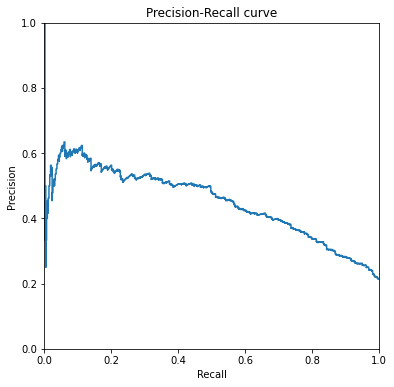

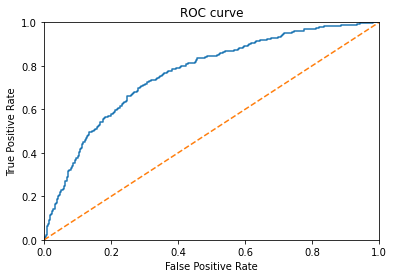

In [8]:
lin_table, lin_precision, lin_recall, lin_fpr, lin_tpr = graphs(lin_raw,valid_features,valid_target,np.arange(0.1,0.75,0.05))

display(lin_table)

plt.figure(figsize=(6, 6))
plt.step(lin_recall, lin_precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

plt.figure()
plt.plot(lin_fpr, lin_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Random Forest Classifier

In [9]:
forest_raw, forest_raw_model = minisearch_forest(train_features,train_target,valid_features,valid_target,range(2, 21, 2),range(10,51,5),None)
forest_balanced, forest_balanced_model = minisearch_forest(train_features,train_target,valid_features,valid_target,range(2, 21, 2),range(10,51,5),'balanced')
forest_up, forest_up_model = minisearch_forest(train_features_up,train_target_up,valid_features,valid_target,range(2, 21, 2),range(10,51,5),None)
forest_down, forest_down_model = minisearch_forest(train_features_down,train_target_down,valid_features,valid_target,range(2, 21, 2),range(10,51,5),None)

In [10]:
forest_raw_model.fit(train_features, train_target)
forest_predicted_valid = forest_raw_model.predict(valid_features)
forest_raw_model_stat = show_stat(valid_target,forest_predicted_valid)

forest_balanced_model.fit(train_features, train_target)
forest_balanced_predicted_valid = forest_balanced_model.predict(valid_features)
forest_balanced_model_stat = show_stat(valid_target,forest_balanced_predicted_valid)

forest_up_model.fit(train_features_up,train_target_up)
forest_up_model_predicted_valid = forest_up_model.predict(valid_features)
forest_up_model_stat = show_stat(valid_target,forest_up_model_predicted_valid)

forest_down_model.fit(train_features_down,train_target_down)
forest_down_model_predicted_valid = forest_down_model.predict(valid_features)
forest_down_model_stat = show_stat(valid_target,forest_down_model_predicted_valid)

final_forest_stat = pd.concat([forest_raw_model_stat,forest_balanced_model_stat,forest_up_model_stat ,forest_down_model_stat],axis=1)
display(final_forest_stat)

,values,values,values,values
stats,,,,
accuracy,0.860500,0.838000,0.847000,0.890000
f1,0.592701,0.643172,0.710775,0.769392
ROC-AUC,0.721510,0.784501,0.863115,0.882553
recall,0.481043,0.691943,0.890995,0.869668
precision,0.771863,0.600823,0.591195,0.689850
TP,203.000000,292.000000,376.000000,367.000000
TN,1518.000000,1384.000000,1318.000000,1413.000000
FP,60.000000,194.000000,260.000000,165.000000
FN,219.000000,130.000000,46.000000,55.000000


,threshold,f1,ROC-AUC,accuracy,recall,precision,TP,TN
0,0.60,0.736501,0.852381,0.8780,0.808057,0.676587,341,1415
1,0.70,0.735437,0.827636,0.8910,0.718009,0.753731,303,1479
2,0.65,0.735062,0.842213,0.8825,0.772512,0.701075,326,1439
3,0.55,0.731658,0.865057,0.8665,0.862559,0.635253,364,1369
4,0.50,0.710775,0.863115,0.8470,0.890995,0.591195,376,1318
5,0.45,0.675958,0.852618,0.8140,0.919431,0.534435,388,1240
6,0.40,0.647011,0.839999,0.7845,0.936019,0.494368,395,1174
7,0.35,0.609594,0.824571,0.7355,0.978673,0.442658,413,1058
8,0.30,0.576738,0.802529,0.6925,0.992891,0.406402,419,966
9,0.25,0.525657,0.758087,0.6210,0.995261,0.357143,420,822


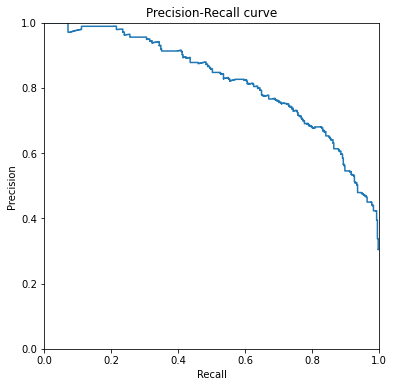

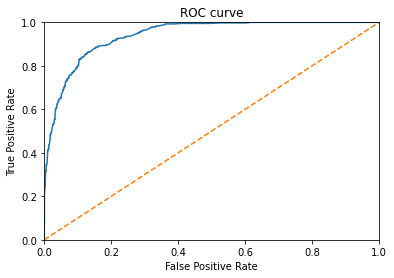

In [11]:
forest_table, forest_precision, forest_recall, forest_fpr, forest_tpr = graphs(forest_up_model,valid_features,valid_target,np.arange(0.1,0.75,0.05))
display(forest_table)

plt.figure(figsize=(6, 6))
plt.step(forest_recall, forest_precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

plt.figure()
plt.plot(forest_fpr, forest_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Decision Tree Classifier

In [12]:
tree_raw, tree_raw_model = minisearch_tree(train_features,train_target,valid_features,valid_target,range(2, 51, 2),None)
tree_balanced, tree_balanced_model = minisearch_tree(train_features,train_target,valid_features,valid_target,range(2, 51, 2),'balanced')
tree_up, tree_up_model = minisearch_tree(train_features_up,train_target_up,valid_features,valid_target,range(2, 51, 2),None)
tree_down, tree_down_model = minisearch_tree(train_features_down,train_target_down,valid_features,valid_target,range(2, 51, 2),None)

In [13]:
tree_raw_model.fit(train_features, train_target)
tree_predicted_valid = tree_raw_model.predict(valid_features)
tree_raw_model_stat = show_stat(valid_target,tree_predicted_valid)

tree_balanced_model.fit(train_features, train_target)
tree_balanced_predicted_valid = tree_balanced_model.predict(valid_features)
tree_balanced_model_stat = show_stat(valid_target,tree_balanced_predicted_valid)

tree_up_model.fit(train_features_up,train_target_up)
tree_up_model_predicted_valid = tree_up_model.predict(valid_features)
tree_up_model_stat = show_stat(valid_target,tree_up_model_predicted_valid)

tree_down_model.fit(train_features_down,train_target_down)
tree_down_model_predicted_valid = tree_down_model.predict(valid_features)
tree_down_model_stat = show_stat(valid_target,tree_down_model_predicted_valid)

final_tree_stat = pd.concat([tree_raw_model_stat,tree_balanced_model_stat,tree_up_model_stat ,tree_down_model_stat],axis=1)
display(final_tree_stat)

,values,values,values,values
stats,,,,
accuracy,0.835000,0.766500,0.779500,0.798000
f1,0.555256,0.581166,0.574735,0.618868
ROC-AUC,0.707954,0.766966,0.752637,0.790400
recall,0.488152,0.767773,0.706161,0.777251
precision,0.643750,0.467532,0.484553,0.514107
TP,206.000000,324.000000,298.000000,328.000000
TN,1464.000000,1209.000000,1261.000000,1268.000000
FP,114.000000,369.000000,317.000000,310.000000
FN,216.000000,98.000000,124.000000,94.000000


,threshold,f1,ROC-AUC,accuracy,recall,precision,TP,TN
0,0.60,0.625369,0.789008,0.8095,0.753555,0.534454,318,1301
1,0.55,0.622010,0.790648,0.8025,0.770142,0.521669,325,1280
2,0.45,0.620561,0.793238,0.7970,0.786730,0.512346,332,1262
3,0.70,0.619860,0.781830,0.8105,0.732227,0.537391,309,1312
4,0.40,0.619355,0.794492,0.7935,0.796209,0.506787,336,1251
5,0.65,0.618905,0.782298,0.8085,0.736967,0.533448,311,1306
6,0.50,0.618868,0.790400,0.7980,0.777251,0.514107,328,1268
7,0.35,0.611465,0.790056,0.7865,0.796209,0.496307,336,1237
8,0.30,0.602283,0.787894,0.7735,0.812796,0.478382,343,1204
9,0.25,0.580968,0.776708,0.7490,0.824645,0.448454,348,1150


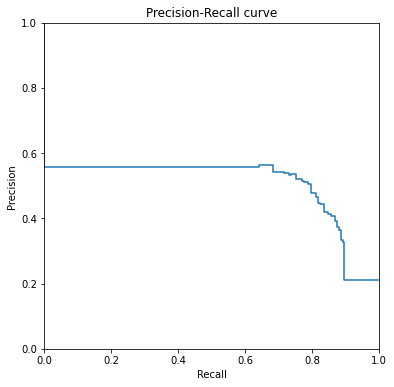

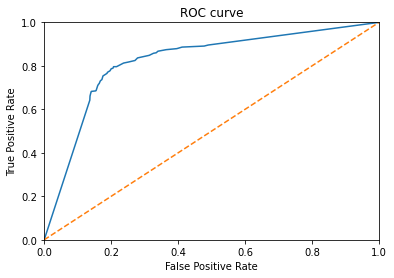

In [14]:
tree_table, tree_precision, tree_recall, tree_fpr, tree_tpr = graphs(tree_down_model,valid_features,valid_target,np.arange(0.1,0.75,0.05))
display(tree_table)

plt.figure(figsize=(6, 6))
plt.step(tree_recall, tree_precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

plt.figure()
plt.plot(tree_fpr, tree_tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

Let's test.

In [15]:
pred1 = forest_up_model.predict(test_features)
show_stat(test_target, pred1)

,values
stats,
accuracy,0.830000
f1,0.668616
ROC-AUC,0.846157
recall,0.872774
precision,0.541864
TP,343.000000
TN,1317.000000
FP,290.000000
FN,50.000000
